In [685]:
import numpy as np
from numba import cuda
import time
import matplotlib.pyplot as plt
from utils import significance_of_mean
import seaborn as sns
import pandas as pd


plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

In [345]:
from scipy.stats import ttest_ind

### Synthetic data

Generating some random data.

In [589]:
np.random.seed(1)
#A = np.asarray([np.random.randint(0,3,5) for _ in range(1)])
#B = np.asarray([np.random.randint(5,15,5) for _ in range(1)])
A = np.asarray([[1,3]])
B = np.asarray([[0,1]])



In [590]:
x = list(A[0])
y = list(B[0])


$\bf{x}=[3, 4, 0, 1, 3]$, $\bf{y}=[0, 0, 1, 4, 4]$, and $\bf{z}=[0, 0, 0, 1, 1, 3, 3, 4, 4, 4]$ with sizes $m=5$, $n=5$, and $m+n=10$, respecitvely. The possible sums $s$ of a $m$-combination from $z$ ranges between $0\leq s \leq 18$.

# \# $j$-combinations s.t. their elements sum is equal to $s$.

Here is the exact algorithm outline in the article.

In [668]:
def getNumerator(x, y, dtype):
    x = [0] + x 
    m = len(x)
    n = len(y)
    z = x + y;z.sort()
    #z = x + y;
    S = sum(z[m:])
    dtype = np.uint16
    print(S)
    print(z)

    N = np.zeros([S + 1, m ], dtype)
    N_old = N.copy()
    
    for i in range(1,(m+n)+1):
        for j in range(1,m +1):
            for s in range( S+1):
                if s==0 and j-1==0:
                    N[s,j-1] = 1
                elif i < j:
                    N[s,j-1] = 0
                elif j > 1 and z[i-1] <= s:
                    N[s,j-1] = N_old[s - z[i -1], j-2] + N_old[s,j-1]
                elif j > 1 and z[i-1] > s:
                    N[s,j-1] = N_old[s,j-1]
        print(N)
        N_old = N.copy()
        
    return N_old[:,-1]

In [669]:
Nsm = getNumerator(x,y, np.float64)

4
[0, 0, 1, 1, 3]
[[1 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]]
[[1 1 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]]
[[1 1 0]
 [0 1 1]
 [0 0 0]
 [0 0 0]
 [0 0 0]]
[[1 1 0]
 [0 2 2]
 [0 0 1]
 [0 0 0]
 [0 0 0]]
[[1 1 0]
 [0 2 2]
 [0 0 1]
 [0 1 1]
 [0 0 2]]


From the calculated $N(s,m)$ the sought of $p$-value can be calculated: $P(s_{\text{obs}} \leq S |x, y)=\sum _{s=s_{obs}}^{\mathcal{S}}\frac{N(s,m)}{{m+n \choose m}}$

In [670]:
def pValue(Numerator, sample):
    return (Numerator.astype(float) / np.sum(Numerator).astype(float))[sum(sample):].sum()

In [744]:
dist = (Nsm / np.sum(Nsm))

In [745]:
dist

array([0.        , 0.33333333, 0.16666667, 0.16666667, 0.33333333])

In [673]:
pValue(Nsm, x)

0.3333333333333333

In [674]:
1 - pValue(Nsm, x)

0.6666666666666667

In [675]:
ttest_ind(x,y)

Ttest_indResult(statistic=1.3416407864998738, pvalue=0.3117527983883147)

In [676]:
Nsm

array([0, 2, 1, 1, 2], dtype=uint16)

In [677]:
data = [[i,n] for i, n in enumerate(Nsm)]

In [662]:
df = pd.DataFrame(data,columns=["Sum", "Number of 2-combinations"])

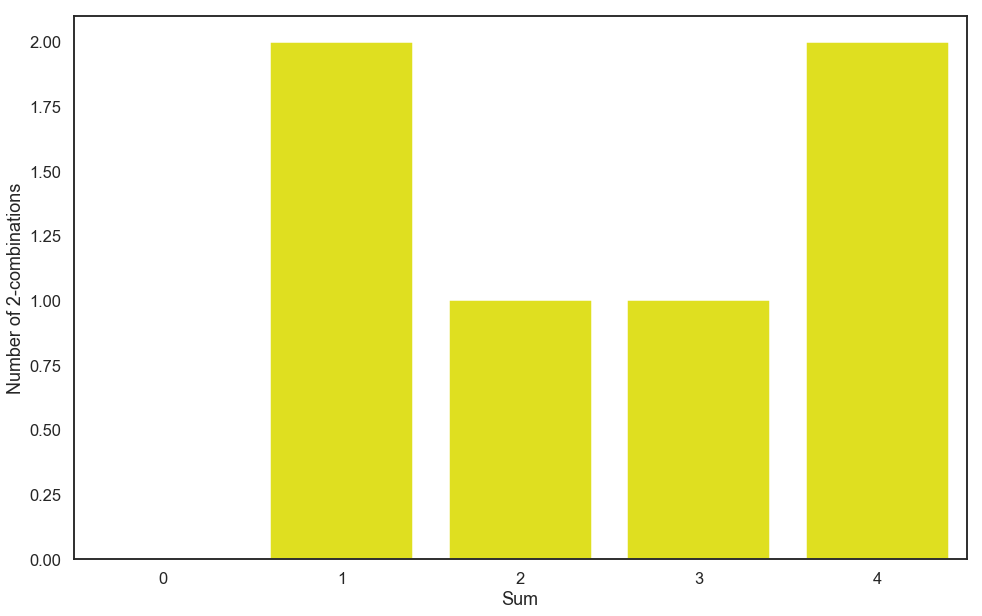

In [663]:
plt.figure(figsize=(16, 10))
barP = sns.barplot(x="Sum", y="Number of 2-combinations", data=df, color="yellow")
sns.set(style="white")
sns.set_context("talk")


In [725]:
data = [[i,n, "1"] if i < 4 else [i,n, "2"] for i, n in enumerate(dist)]

In [737]:
clr = ["lightblue", "lightblue", "lightblue", "blue"]

In [726]:
df = pd.DataFrame(data,columns=["Sum", "Probability (%)", "color"])

In [727]:
!mkdir "figures/exampleFigure"

mkdir: cannot create directory ‘figures/exampleFigure’: File exists


In [728]:
!ls "figures/exampleFigure/distribution"

ls: cannot access 'figures/exampleFigure/distribution': No such file or directory


In [731]:
data

[[0, 0.0, '1'],
 [1, 0.3333333333333333, '1'],
 [2, 0.16666666666666666, '1'],
 [3, 0.16666666666666666, '1'],
 [4, 0.3333333333333333, '2']]

In [741]:
clr = ["lightblue", "lightblue", "lightblue","lightblue", "blue"]

In [743]:
Nsm

array([0, 2, 1, 1, 2], dtype=uint16)

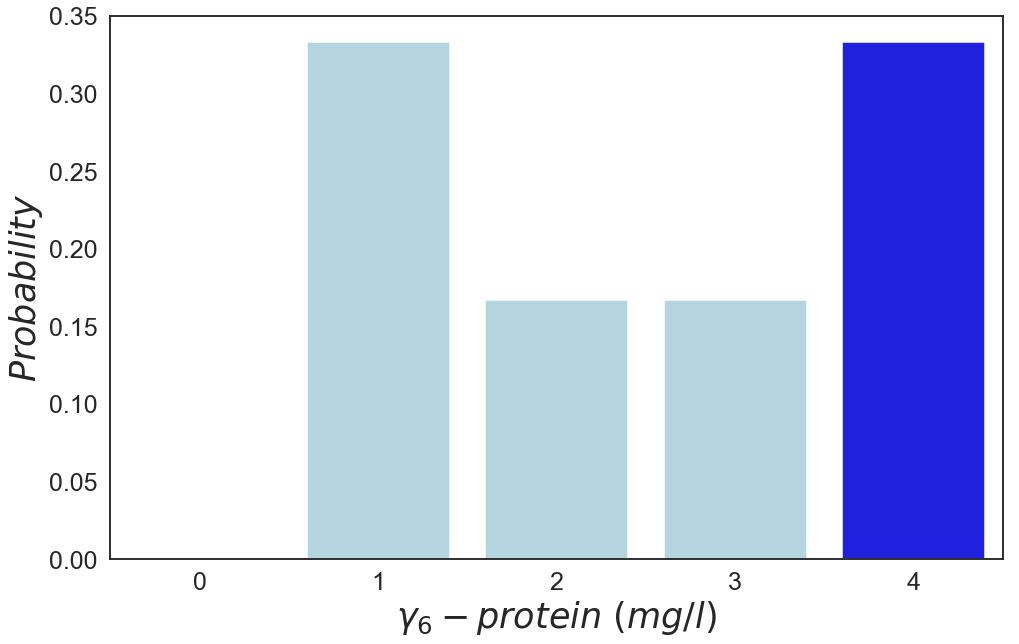

In [750]:
plt.figure(figsize=(16, 10))
#barP = sns.barplot(x="Sum", y="Probability (%)", data=df ,hue="color", palette ={"1":"lightblue", "2":"blue"})

barP = sns.barplot(x=list(range(len(Nsm))), 
                   y=dist, 
                   palette =clr)
sns.set(style="white")
sns.set_context("talk")


plt.xlabel(r"$\gamma _{6}-protein\ (mg/l)$", fontsize=35)
plt.ylabel(r"$Probability$",fontsize=35)
plt.xticks(size = 25)
plt.yticks(size = 25)

plt.savefig("figures/exampleFigure/distribution")

In [730]:
import operator as op
from functools import reduce

def ncr(n, r):
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer / denom

In [716]:
ncr(4,2)

6.0

In [717]:
Nsm.sum()

6

In [718]:
2/6

0.3333333333333333

The $p-value=0.464$

# Parallelization of algorithm

It is the two inner for-loops that can parallelized i.e., by keeping $i$ constant, $j$ and $s$ is paralellizible. Let's write those two loops in Numba.

In [8]:
@cuda.jit("(u8[:,:], u8[:,:], u8, u8[:],u8)")
def fill_array_u4_v_u2(X1,X2, i_, z_,S):
    n = X1.shape[0]
    m = X1.shape[1]

    s, j = cuda.grid(2)
    
    if j >= m + 1 or s > S or j < 1:
        return
    
    if s==0 and int(j-1)==0:
        X2[s,j -1] = 1
    
    if i_ < j:
        X2[s, j - 1] = 0
        
    elif j>1 and z_[i_ - 1] <= s:
        X2[s, j - 1] = X1[s - int(z_[i_ - 1]), j - 2] + X1[s, j - 1]
    
    elif j>1 and z_[i_ - 1] > s:
        X2[s, j-1] = X1[s,j-1]
    

The getNumerator can now be rewritten with this new function to get it parallelized.

In [9]:
def getNumeratorParallelized(A0, A1, dA0, dA1, m, n, S, dz, threadsperblock, blockspergrid, stream):
    for i in range(1, (m+n) + 1):
        fill_array_u4_v_u2[blockspergrid, threadsperblock, stream](dA0, dA1, np.uint64(i), dz, S)
        
        
        tmp = dA0
        dA0 = dA1
        dA1 = tmp
        
        
        
    dA0.to_host(stream)

    
    return A1[:,-1]

Here is some necessary initial step to use the GPU: Initiate array to write, and threadblocks and blockgrids on the GPU.

In [10]:
def runParalellized(x, y):
    x = [0] + x 
    m = len(x)
    n = len(y)
    z = x + y;z.sort()
    S = sum(z[m:])
    dtype = np.uint64
    
    z = np.array(z, dtype)
    
    A0 = np.zeros([int(S) + 1, m], np.uint64)
    NN, NM = A0[:, :].shape
        
    threadsperblock = (64, 4)
    blockspergrid = (int(np.ceil((NN)/ threadsperblock[0])),
                     int(np.ceil(NM/threadsperblock[1] + 1))
                    )
            
    A1 = np.zeros([int(S) + 1, m], np.uint64)
    
    stream = cuda.stream()
    dz, dA0, dA1 = cuda.to_device(z, stream), cuda.to_device(A0, stream), cuda.to_device(A1, stream)
    
    return getNumeratorParallelized(A0,A1, dA0, dA1, m, n, S, dz, threadsperblock, blockspergrid, stream)
    

In [11]:
NsmP = runParalellized(x,y)

Verify so they yield the same answer.

In [13]:
np.allclose(NsmP, Nsm)

True